In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout patch-22.12
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

# Install the Merlin Framework
!pip install -U git+https://github.com/NVIDIA-Merlin/models.git

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 400 (delta 95), reused 53 (delta 51), pack-reused 269
Receiving objects: 100% (400/400), 109.81 KiB | 864.00 KiB/s, done.
Resolving deltas: 100% (197/197), done.
/content/rapidsai-csp-utils
error: pathspec 'patch-22.12' did not match any file(s) known to git
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************

***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip

In [ ]:
!pip install -U git+https://github.com/NVIDIA-Merlin/nvtabular.git
!pip install -U git+https://github.com/NVIDIA-Merlin/core.git
!pip install -U git+https://github.com/NVIDIA-Merlin/systems.git
!pip install -U git+https://github.com/NVIDIA-Merlin/dataloader.git
!pip install -U git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git
!pip install -U xgboost lightfm implicit

  Cloning https://github.com/NVIDIA-Merlin/nvtabular.git to /tmp/pip-req-build-4xousyx2
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/nvtabular.git /tmp/pip-req-build-4xousyx2
  Resolved https://github.com/NVIDIA-Merlin/nvtabular.git to commit 9f0ba3379333eb95fbb9222faa00ca1658a28a7f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvtabular: filename=nvtabular-23.8.0+2.g9f0ba337-cp310-cp310-linux_x86_64.whl size=248838 sha256=3469a17b6f2458e3376e92d2a88d89bcaa300a745e146e63a1c845d7f4b2a3a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-3tldz68e/wheels/3d/58/4d/cdb4b94f0b7c6c4c9962d0f68a7cdb25f9b00e6092e4bc785b
Successfully built nvtabular
  Cloning https://github.com/NVIDIA-Merlin/core.git to /tmp/pip-req-build-lkr_hjvl
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/core.git /tmp/pip-req-build-lk

In [ ]:
!pip install tritonclient[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 34.0 MB/s eta 0:00:00


In [ ]:
import os
import torch
import cudf
from merlin.io import Dataset
from nvtabular import Workflow

from merlin.systems.dag import Ensemble
from merlin.systems.dag.ops.pytorch import PredictPyTorch
from merlin.systems.dag.ops.workflow import TransformWorkflow
from merlin.table import TensorTable, TorchColumn
from merlin.table.conversions import convert_col

In [ ]:
from numba import config
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0

In [ ]:
df = cudf.read_parquet('/content/drive/MyDrive/output_1.parquet')

In [ ]:
import nvtabular as nvt

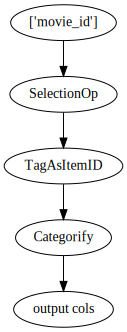

In [ ]:
movie_id = ['movie_id'] >> nvt.ops.TagAsItemID()>> nvt.ops.Categorify()
movie_id.graph

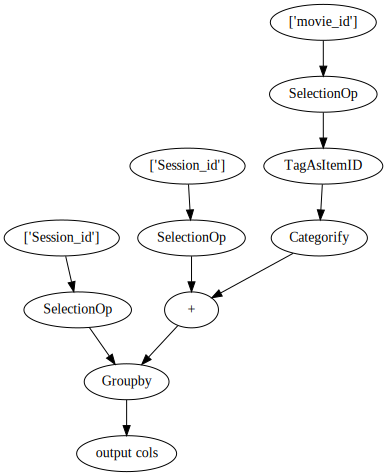

In [ ]:
feature_list = ['Session_id']+ movie_id
#initial test with only the sequence of movies.
groupby_features = feature_list >> nvt.ops.Groupby(groupby_cols=['Session_id'], aggs={'movie_id': 'list'})
groupby_features.graph
# workflow = nvt.Workflow(groupby_features)

In [ ]:
groupby_features_list = groupby_features['movie_id_list']

In [ ]:
SESSIONS_MAX_LENGTH = 20
MINIMUM_SESSION_LENGTH = 2

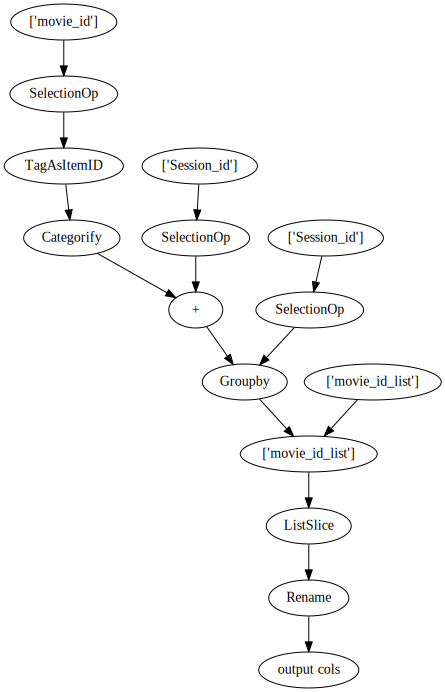

In [ ]:
groupby_features_trim = groupby_features_list >> nvt.ops.ListSlice(0,SESSIONS_MAX_LENGTH, pad = True) >> nvt.ops.Rename(postfix='_seq')
groupby_features_trim.graph

In [ ]:
sess_id = groupby_features['Session_id'] >> nvt.ops.AddMetadata(tags=[Tags.CATEGORICAL])
selected_features = sess_id + groupby_features_trim

In [ ]:
workflow = nvt.Workflow(groupby_features_trim)

In [ ]:
num_sessions = len(df['Session_id'].unique())
print(num_sessions)

80902


In [ ]:
train = int(0.9 * num_sessions)
test = num_sessions- train
print(train)
print(test)

72811
8091


In [ ]:
train_indices= cudf.Series(cudf.core.index.RangeIndex(0, train))
print(train_indices)

0            0
1            1
2            2
3            3
4            4
         ...  
72806    72806
72807    72807
72808    72808
72809    72809
72810    72810
Length: 72811, dtype: int64


In [ ]:
train_df = df.take(train_indices)
test_df = df.drop(train_indices)
train_df = train_df[train_df['Session_id'] != 7019]

In [ ]:
dataset = nvt.Dataset(df)
workflow.fit_transform(dataset).to_parquet(os.path.join('/content/drive/MyDrive/movie_rec_transformer', "total_nvt"))

In [ ]:
dataset = nvt.Dataset(train_df)
workflow.fit_transform(dataset).to_parquet(os.path.join('/content/drive/MyDrive/movie_rec_transformer', "train_nvt"))

In [ ]:
workflow.output_schema.column_names

['movie_id_list_seq']

In [ ]:
dataset = nvt.Dataset(test_df)
workflow.fit_transform(dataset).to_parquet(os.path.join('/content/drive/MyDrive/movie_rec_transformer', "test_nvt"))

In [ ]:
import os
import glob

import torch
import transformers4rec.torch as tr
from transformers4rec.torch.ranking_metric import NDCGAt, RecallAt
from transformers4rec.torch.utils.examples_utils import wipe_memory

In [ ]:
from merlin.schema import Schema
from merlin.io import Dataset

train = Dataset('/content/drive/MyDrive/movie_rec_transformer/train_nvt/part_0.parquet', engine="parquet")
test = Dataset('/content/drive/MyDrive/movie_rec_transformer/test_nvt/part_0.parquet', engine="parquet")
total = Dataset('/content/drive/MyDrive/movie_rec_transformer/total_nvt/part_0.parquet', engine="parquet")
schema = total.schema

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training GRU

In [ ]:
sequence_length = 20
inputs = tr.TabularSequenceFeatures.from_schema(
        schema,
        max_sequence_length= sequence_length,
        masking = 'causal',
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
d_model = 128
body = tr.SequentialBlock(
        inputs,
        tr.MLPBlock([d_model]),
        tr.Block(torch.nn.GRU(input_size=d_model, hidden_size=d_model, num_layers=1), [None, 20, d_model])
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
head = tr.Head(
    body,
    tr.NextItemPredictionTask(weight_tying=True,
                              metrics=[NDCGAt(top_ks=[10, 20], labels_onehot=True),
                                       RecallAt(top_ks=[10, 20], labels_onehot=True)]),
    inputs=inputs,
)
model = tr.Model(head)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from transformers4rec.config.trainer import T4RecTrainingArguments
from transformers4rec.torch import Trainer

#Set arguments for training
train_args = T4RecTrainingArguments(local_rank = -1,
                                    dataloader_drop_last = False,
                                    report_to = [],   #set empy list to avoig logging metrics to Weights&Biases
                                    gradient_accumulation_steps = 1,
                                    per_device_train_batch_size = 256,
                                    per_device_eval_batch_size = 32,
                                    output_dir = "./tmp",
                                    max_sequence_length=sequence_length,
                                    learning_rate=0.00071,
                                    num_train_epochs=3,
                                    logging_steps=200,
                                   )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Instantiate the T4Rec Trainer, which manages training and evaluation
trainer = Trainer(
    model=model,
    args=train_args,
    schema=schema,
    compute_metrics=True,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
trainer.train_dataset_or_path = train
trainer.reset_lr_scheduler()
trainer.train()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=84, training_loss=7.613470894949777, metrics={'train_runtime': 2.066, 'train_samples_per_second': 10408.584, 'train_steps_per_second': 40.659, 'total_flos': 0.0, 'train_loss': 7.613470894949777})

In [ ]:
trainer.eval_dataset_or_path = test

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_metrics = trainer.evaluate(metric_key_prefix='eval')
print('\n' + '*'*20 + '\n')
for key in sorted(train_metrics.keys()):
    print(" %s = %s" % (key, str(train_metrics[key])))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



********************

 eval_/loss = 7.49004602432251
 eval_/next-item/ndcg_at_10 = 0.01208285428583622
 eval_/next-item/ndcg_at_20 = 0.01845126785337925
 eval_/next-item/recall_at_10 = 0.025634778663516045
 eval_/next-item/recall_at_20 = 0.05114774405956268
 eval_runtime = 20.6702
 eval_samples_per_second = 3574.622
 eval_steps_per_second = 111.707


In [ ]:
with open("/content/drive/MyDrive/movie_rec_transformer/results.txt", 'w') as f:
    f.write('GRU accuracy results:')
    f.write('\n')
    for key, value in  model.compute_metrics().items():
        f.write('%s:%s\n' % (key, value.item()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training Xlnet

In [ ]:
#Input
sequence_length, d_model = 20, 64
# Define input module to process tabular input-features and to prepare masked inputs
inputs= tr.TabularSequenceFeatures.from_schema(
    schema,
    max_sequence_length=sequence_length,
    d_output=d_model,
    masking="mlm",
)

In [ ]:
# Define XLNetConfig class and set default parameters for HF XLNet config
transformer_config = tr.XLNetConfig.build(
    d_model=d_model, n_head=4, n_layer=2, total_seq_length=sequence_length
)
# Define the model block including: inputs, masking, projection and transformer block.
body = tr.SequentialBlock(
    inputs, tr.MLPBlock([64]), tr.TransformerBlock(transformer_config, masking=inputs.masking)
)

# Define the head for to next item prediction task
head = tr.Head(
    body,
    tr.NextItemPredictionTask(weight_tying=True,
                              metrics=[NDCGAt(top_ks=[10, 20], labels_onehot=True),
                                       RecallAt(top_ks=[10, 20], labels_onehot=True)]),
)

# Get the end-to-end Model class
model = tr.Model(head)

In [ ]:
from transformers4rec.config.trainer import T4RecTrainingArguments
from transformers4rec.torch import Trainer

#Set arguments for training
training_args = T4RecTrainingArguments(
            output_dir="./tmp",
            max_sequence_length=20,
            data_loader_engine='merlin',
            num_train_epochs=5,
            dataloader_drop_last=False,
            per_device_train_batch_size = 256,
            per_device_eval_batch_size = 32,
            gradient_accumulation_steps = 1,
            learning_rate=0.000666,
            report_to = [],
            logging_steps=50,
        )

In [ ]:
# Instantiate the T4Rec Trainer, which manages training and evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    schema=schema,
    compute_metrics=True,
)

In [ ]:
trainer.train_dataset_or_path = train

In [ ]:
trainer.reset_lr_scheduler()
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
50,7.924000
100,7.541700


TrainOutput(global_step=140, training_loss=7.65919669015067, metrics={'train_runtime': 3.7809, 'train_samples_per_second': 9479.229, 'train_steps_per_second': 37.028, 'total_flos': 0.0, 'train_loss': 7.65919669015067})

In [ ]:
trainer.eval_dataset_or_path = test

In [ ]:
train_metrics = trainer.evaluate(metric_key_prefix='eval')
print('\n' + '*'*20 + '\n')
for key in sorted(train_metrics.keys()):
    print(" %s = %s" % (key, str(train_metrics[key])))


********************

 eval_/loss = 7.493791580200195
 eval_/next-item/ndcg_at_10 = 0.012072729878127575
 eval_/next-item/ndcg_at_20 = 0.01801828108727932
 eval_/next-item/recall_at_10 = 0.025350550189614296
 eval_/next-item/recall_at_20 = 0.04911753535270691
 eval_runtime = 31.7738
 eval_samples_per_second = 2325.44
 eval_steps_per_second = 72.67


In [ ]:
model.save("/content/drive/MyDrive/movie_rec_transformer/saved_model")

In [ ]:
workflow = Workflow.load("/content/drive/MyDrive/movie_rec_transformer/workflow_etl")

In [ ]:
df = cudf.read_parquet("/content/drive/MyDrive/movie_rec_transformer/total_nvt/part_0.parquet", columns=model.input_schema.column_names)
table = TensorTable.from_df(df.iloc[:100])
for column in table.columns:
    table[column] = convert_col(table[column], TorchColumn)
model_input_dict = table.to_dict()

In [ ]:
topk = 20
model.top_k = topk

In [ ]:
model.eval()
traced_model = torch.jit.trace(model, model_input_dict, strict=True)


In [ ]:
torch.jit.save(traced_model, "traced.pt")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
loaded_model = torch.jit.load("traced.pt")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
loaded_model.parameters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Module.parameters of RecursiveScriptModule(
  original_name=Model
  (heads): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Head
      (body): RecursiveScriptModule(
        original_name=SequentialBlock
        (0): RecursiveScriptModule(
          original_name=TabularSequenceFeatures
          (to_merge): RecursiveScriptModule(
            original_name=ModuleDict
            (categorical_module): RecursiveScriptModule(
              original_name=SequenceEmbeddingFeatures
              (filter_features): RecursiveScriptModule(original_name=FilterFeatures)
              (embedding_tables): RecursiveScriptModule(
                original_name=ModuleDict
                (movie_id_list_seq): RecursiveScriptModule(original_name=Embedding)
              )
            )
            (pretrained_embedding_module): RecursiveScriptModule(
              original_name=PretrainedEmbeddingFeatures
              (filter_feature

In [ ]:
loaded_model.eval()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RecursiveScriptModule(
  original_name=Model
  (heads): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Head
      (body): RecursiveScriptModule(
        original_name=SequentialBlock
        (0): RecursiveScriptModule(
          original_name=TabularSequenceFeatures
          (to_merge): RecursiveScriptModule(
            original_name=ModuleDict
            (categorical_module): RecursiveScriptModule(
              original_name=SequenceEmbeddingFeatures
              (filter_features): RecursiveScriptModule(original_name=FilterFeatures)
              (embedding_tables): RecursiveScriptModule(
                original_name=ModuleDict
                (movie_id_list_seq): RecursiveScriptModule(original_name=Embedding)
              )
            )
            (pretrained_embedding_module): RecursiveScriptModule(
              original_name=PretrainedEmbeddingFeatures
              (filter_features): RecursiveScriptModule(original_

In [ ]:
model_input_dict['movie_id_list_seq__values']

tensor([703,  11,  86,  ...,   0,   0,   0], device='cuda:0')

In [ ]:
input_schema = model.input_schema
output_schema = model.output_schema

In [ ]:
import shutil
ens_model_path = "/content/drive/MyDrive/movie_rec_transformer/models"
# Make sure we have a clean stats space for Dask
if os.path.isdir(ens_model_path):
    shutil.rmtree(ens_model_path)
os.mkdir(ens_model_path)

In [ ]:
torch_op = workflow.input_schema.column_names >> TransformWorkflow(workflow) >> PredictPyTorch(
    traced_model, input_schema, output_schema
)

ensemble = Ensemble(torch_op, workflow.input_schema)

In [ ]:
ensemble.input_schema

,name,tags,dtype,is_list,is_ragged
0,movie_id,(),"DType(name='int64', element_type=<ElementType....",False,False
1,Session_id,(),"DType(name='int64', element_type=<ElementType....",False,False


In [ ]:
# from nvtabular.inference.triton import export_pytorch_ensemble
# export_pytorch_ensemble(
#     model,
#     workflow,
#     sparse_max=sparse_features_max,
#     name= "t4r_pytorch",
#     model_path= "/content/drive/MyDrive/movie_rec_transformer/models",
#     label_columns =[],
# )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored